In [1]:
import uproot as ut
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from uproot3_methods import TLorentzVectorArray
import vector
import awkward as ak
from tqdm import tqdm
%matplotlib inline

import numpy as np

from preselUtils import *

In [2]:
filename = "../signal/NanoAOD/NMSSM_XYH_YToHH_6b_MX_700_MY_400_accstudies_500k_May2021.root:sixBtree"
ttree = ut.open(filename)
branches_all = ttree.arrays()
nevents_all = ak.size( branches_all["Run"] )

In [3]:
total_events = 10000
branches = branches_all[:total_events]
nevents = ak.size( branches["Run"] )

In [4]:
nevt_mask = lambda n: ak.Array( [True]*n + [False]*(nevents-n) )

In [5]:
sixb_gen_match_mask = branches["nfound_all"] == 6
nsignal = ak.sum(sixb_gen_match_mask)
sixb_selected = select_sixb(branches)

100%|██████████| 10000/10000 [00:00<00:00, 11722.02it/s]


In [6]:
def plot_simple(variable,branches=branches,mask=None,selected=None,bins=None,xlabel=None,title="No Selection",label=None,figax=None):
    if figax is None: figax = plt.subplots()
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    (fig,ax) = figax
    
    data = branches[variable][mask]
    if selected is not None: data = branches[variable][mask][selected]
    data = ak.flatten( data,axis=-1 )
    
    ax.hist(data,bins=bins,label=label)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
def plot_mask_comparison(variable,branches=branches,mask=None,selected=None,signal_selected=None,sixb_selected=None
                              ,bins=None,xlabel=None,title="No Selection",label="All Events",figax=None):
    if figax is None: figax = plt.subplots()
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    (fig,ax) = figax
    
    data1 = branches[variable][mask]
    if selected is not None and "jet_" in variable: data1 = branches[variable][mask][selected]
    data1 = ak.flatten( data1,axis=-1 ); nevts1 = len(data1)
    
    data2 = branches[variable][mask & sixb_gen_match_mask]
    if signal_selected is not None and "jet_" in variable: data2 = branches[variable][mask & sixb_gen_match_mask][signal_selected]
    data2 = ak.flatten( data2,axis=-1 ); nevts2 = len(data2)
    
    data3 = branches[variable][mask & sixb_gen_match_mask]
    if sixb_selected is not None and "jet_" in variable: data3 = branches[variable][mask & sixb_gen_match_mask][sixb_selected[mask & sixb_gen_match_mask]]
    data3 = ak.flatten( data3,axis=-1 ); nevts3 = len(data3)
    
    ax.hist(data1,bins=bins,label=f"{label} ({nevts1:.2e})")
    ax.hist(data2,bins=bins,label=f"Gen Matched Six BJets ({nevts2:.2e})")
    
    if sixb_selected is not None and "jet_" in variable:
        ax.hist(data3,bins=bins,label=f"Signal Six BJets ({nevts3:.2e})",histtype="step",color="black",linewidth=2)
        
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
    
def plot_mask_simple_comparison(selected,signal_selected,bins=None,label="All Events",title=None,xlabel=None,figax=None):
    if figax is None: figax = plt.subplots()
    (fig,ax) = figax
        
    nevts1 = ak.size(selected)
    nevts2 = ak.size(signal_selected)
        
    ax.hist(selected,bins=bins,label=f"{label} ({nevts1:.2e})")
    ax.hist(signal_selected,bins=bins,label=f"Gen Matched Six BJets ({nevts2:.2e})")
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
    
def presel_study(branches=branches,mask=np.ones(nevents,dtype=bool),jet_mask=None,
                 selected=None,signal_selected=None,sixb_selected=sixb_selected,sixb_count=None,signal_sixb_count=None,
                 title="No Selection",saveas=None):
    print(f"--- {title} ---")
    varinfo = {
        f"jet_ptRegressed":{"bins":np.linspace(0,200,100),"xlabel":"Jet Pt (GeV)"},
        f"jet_eta":{"bins":np.linspace(-3,3,100),"xlabel":"Jet Eta"},
        f"jet_phi":{"bins":np.linspace(-3.14,3.14,100),"xlabel":"Jet Phi"},
        f"jet_deepJet":{"bins":np.linspace(0,1,100),"xlabel":"Jet Btag"},
    }
    mask_evnts = ak.sum(mask)
    signal_evnts= ak.sum(mask & sixb_gen_match_mask)
    
    total_eff = mask_evnts/float(nevents)
    signal_eff = signal_evnts/float(nsignal)
    purity = signal_evnts/float(mask_evnts)
    
    prompt = [
        f"Event Efficiency:       {total_eff:0.2f}",
        f"Signal Efficiency:      {signal_eff:0.2f}",
        f"Signal Purity:          {purity:0.2f}"
    ]
    
    if sixb_count is not None:
        total_score = sum( ak.sum(sixb_count == n)/float(6+1-n) for n in range(6+1))/float(mask_evnts)
        signal_score= sum( ak.sum(signal_sixb_count == n)/float(6+1-n) for n in range(6+1))/float(signal_evnts)
        prompt += [
            f"Event Selection Score:  {total_score:0.2f}",
            f"Signal Selection Score: {signal_score:0.2f}"
        ]
    
    print("\n".join(prompt))
    
    total_njet = branches["njet"][mask]
    if jet_mask is not None: total_njet = ak.sum(jet_mask[mask],axis=-1)
    
    signal_njet = branches["njet"][mask & sixb_gen_match_mask]
    if jet_mask is not None: signal_njet = ak.sum(jet_mask[mask & sixb_gen_match_mask],axis=-1)
    
    fig = plt.figure( figsize=(20,10) )
    gs = fig.add_gridspec(nrows=2,ncols=4)
    
    ax1 = fig.add_subplot( gs[0,:2])
    ax2 = fig.add_subplot( gs[0,2:])
    
    plot_mask_simple_comparison(total_njet,signal_njet,figax=(fig,ax1),title=title,bins=np.linspace(-0.5,21.5,23),xlabel="Number of Jets in Selection")
    plot_mask_simple_comparison(sixb_count,signal_sixb_count,figax=(fig,ax2),title=title,bins=np.linspace(-0.5,6.5,8),xlabel="N Signal Six B in Selection")
    
    for i,(var,info) in enumerate(varinfo.items()):
        ax = fig.add_subplot( gs[1,i] )
        plot_mask_comparison(var,branches=branches,mask=mask,selected=selected,signal_selected=signal_selected,
                             sixb_selected=sixb_selected,title=title,figax=(fig,ax),**info)
    fig.tight_layout()
    plt.show()
    if saveas: fig.savefig(f"plots/{saveas}")
    

In [7]:
(pt_selected,sixb_count_pt),(signal_pt_selected,signal_sixb_count_pt) = get_selected(branches,"jet_ptRegressed",sixb_selected=sixb_selected,sixb_gen_match_mask=sixb_gen_match_mask)

100%|██████████| 3602/3602 [00:00<00:00, 10492.39it/s]


In [8]:
(btag_selected,sixb_count_btag),(signal_btag_selected,signal_sixb_count_btag) = get_selected(branches,"jet_deepJet",sixb_selected=sixb_selected,sixb_gen_match_mask=sixb_gen_match_mask)

100%|██████████| 3602/3602 [00:00<00:00, 10615.29it/s]


--- 6 Highest Pt Jets ---
Event Efficiency:       1.00
Signal Efficiency:      1.00
Signal Purity:          0.36
Event Selection Score:  0.44
Signal Selection Score: 0.55


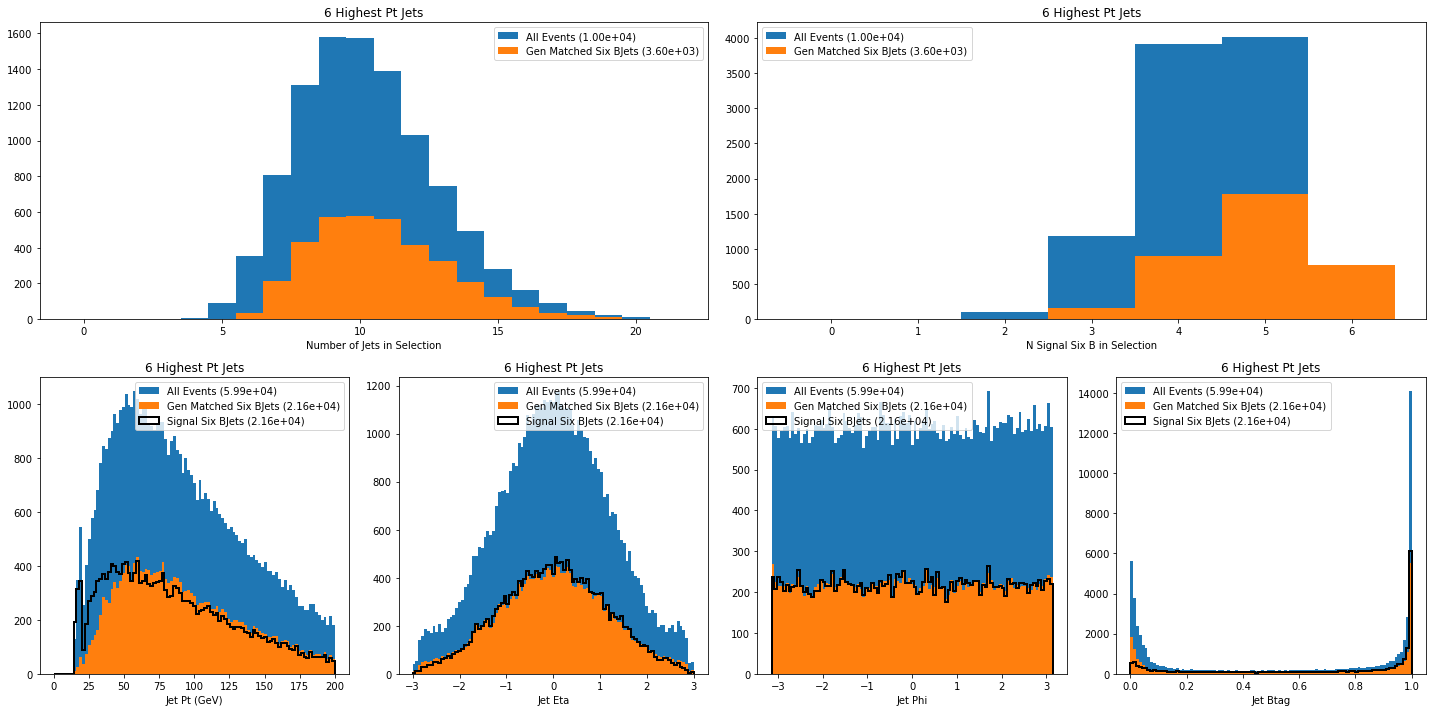

In [9]:
info = {
    "title":"6 Highest Pt Jets",
    "selected":pt_selected,
    "signal_selected":signal_pt_selected,
    "sixb_count":sixb_count_pt,
    "signal_sixb_count":signal_sixb_count_pt,
    "saveas":"no_sel_high_pt.png"
}
presel_study(**info)

--- 6 Highest Btag Jets ---
Event Efficiency:       1.00
Signal Efficiency:      1.00
Signal Purity:          0.36
Event Selection Score:  0.36
Signal Selection Score: 0.45


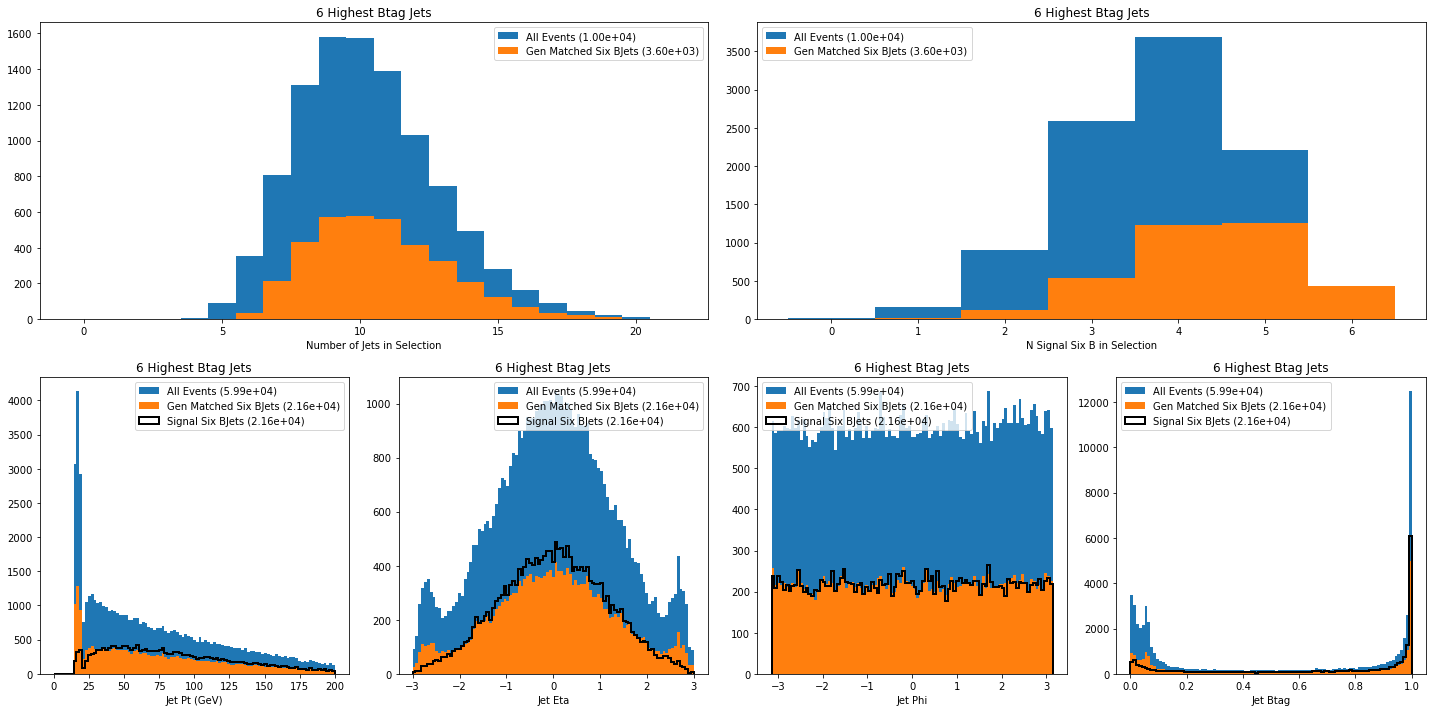

In [10]:
info = {
    "title":"6 Highest Btag Jets",
    "selected":btag_selected,
    "signal_selected":signal_btag_selected,
    "sixb_count":sixb_count_btag,
    "signal_sixb_count":signal_sixb_count_btag,
    "saveas":"no_sel_high_btag.png"
}
presel_study(**info)

In [11]:
# --- Standard Preselection --- #
def std_preselection(branches,ptcut=30,etacut=2.4,btagcut=-1):
    jet_pt_mask = branches["jet_ptRegressed"] > ptcut
    jet_eta_mask = np.abs(branches["jet_eta"]) < etacut
    jet_btag_mask = branches["jet_deepJet"] > btagcut
    
    jet_mask = jet_pt_mask & jet_eta_mask & jet_btag_mask
    event_mask = ak.sum(jet_mask,axis=-1) >= 6
    return event_mask,jet_mask
event_presel_mask, jet_presel_mask = std_preselection(branches)

In [12]:
(pt_preselected,sixb_count_presel_pt),(signal_pt_preselected,signal_sixb_count_presel_pt) = get_selected(branches,"jet_ptRegressed",mask=event_presel_mask,
                                                                                                         jets=jet_presel_mask,sixb_selected=sixb_selected,
                                                                                                         sixb_gen_match_mask=sixb_gen_match_mask)

100%|██████████| 2816/2816 [00:00<00:00, 9649.21it/s]


In [13]:
(btag_preselected,sixb_count_presel_btag),(signal_btag_preselected,signal_sixb_count_presel_btag) = get_selected(branches,"jet_deepJet",mask=event_presel_mask,
                                                                                                                 jets=jet_presel_mask,sixb_selected=sixb_selected,
                                                                                                                 sixb_gen_match_mask=sixb_gen_match_mask)

100%|██████████| 2816/2816 [00:00<00:00, 10360.58it/s]


--- STD Preselection 6 Highest Pt ---
Event Efficiency:       0.63
Signal Efficiency:      0.78
Signal Purity:          0.44
Event Selection Score:  0.47
Signal Selection Score: 0.58


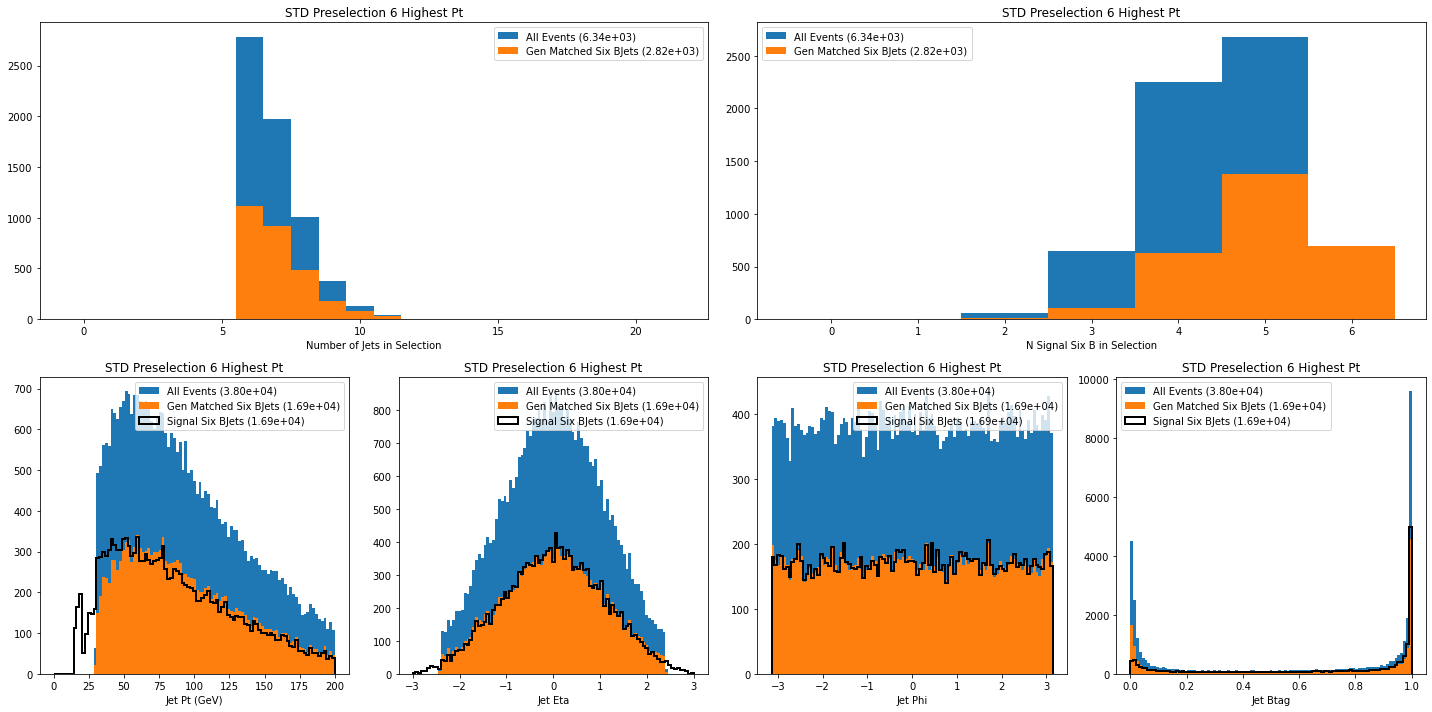

In [14]:
info = {
    "mask":event_presel_mask,
    "title":"STD Preselection 6 Highest Pt",
    "selected":pt_preselected,
    "signal_selected":signal_pt_preselected,
    "sixb_count":sixb_count_presel_pt,
    "signal_sixb_count":signal_sixb_count_presel_pt,
    "jet_mask":jet_presel_mask,
    "saveas":"presel_std_high_pt.png"
}
presel_study(**info)

--- STD Preselection 6 Highest Btag ---
Event Efficiency:       0.63
Signal Efficiency:      0.78
Signal Purity:          0.44
Event Selection Score:  0.45
Signal Selection Score: 0.56


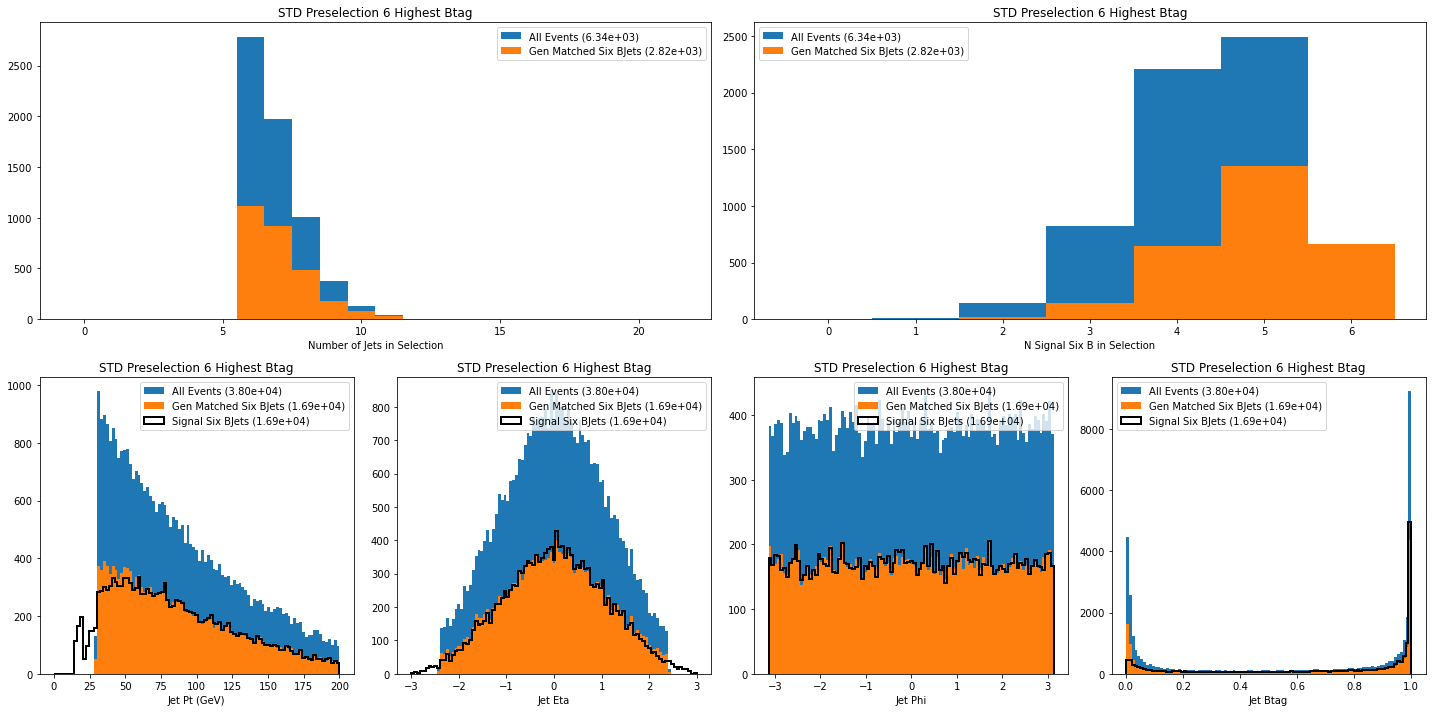

In [15]:
info = {
    "mask":event_presel_mask,
    "title":"STD Preselection 6 Highest Btag",
    "selected":btag_preselected,
    "signal_selected":signal_btag_preselected,
    "sixb_count":sixb_count_presel_btag,
    "signal_sixb_count":signal_sixb_count_presel_btag,
    "jet_mask":jet_presel_mask,
    "saveas":"presel_std_high_btag.png"
}
presel_study(**info)

In [16]:
event_presel_v2_mask, jet_presel_v2_mask = std_preselection(branches,btagcut=0.05)
(pt_v2_preselected,sixb_count_v2_presel_pt),(signal_pt_v2_preselected,signal_sixb_count_v2_presel_pt) = get_selected(branches,"jet_ptRegressed",mask=event_presel_v2_mask,
                                                                                                                     jets=jet_presel_v2_mask,sixb_selected=sixb_selected,
                                                                                                                     sixb_gen_match_mask=sixb_gen_match_mask)

100%|██████████| 1346/1346 [00:00<00:00, 10643.84it/s]


In [17]:
(btag_v2_preselected,sixb_count_v2_presel_btag),(signal_btag_v2_preselected,signal_sixb_count_v2_presel_btag) = get_selected(branches,"jet_deepJet",mask=event_presel_v2_mask,
                                                                                                                             jets=jet_presel_v2_mask,sixb_selected=sixb_selected,
                                                                                                                             sixb_gen_match_mask=sixb_gen_match_mask)

100%|██████████| 1346/1346 [00:00<00:00, 10973.86it/s]


--- STD Preselection v2 Highest Pt ---
Event Efficiency:       0.21
Signal Efficiency:      0.37
Signal Purity:          0.64
Event Selection Score:  0.68
Signal Selection Score: 0.82


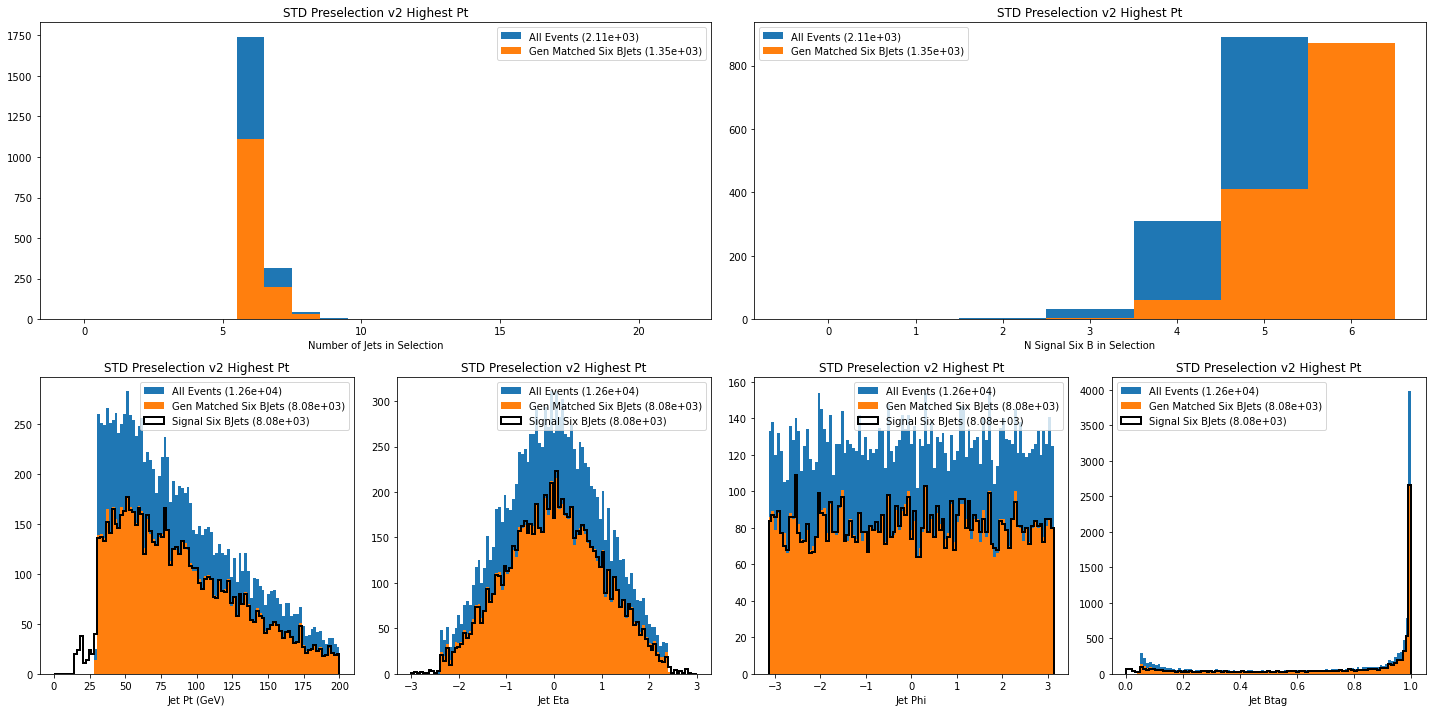

In [18]:
info = {
    "mask":event_presel_v2_mask,
    "title":"STD Preselection v2 Highest Pt",
    "selected":pt_v2_preselected,
    "signal_selected":signal_pt_v2_preselected,
    "sixb_count":sixb_count_v2_presel_pt,
    "signal_sixb_count":signal_sixb_count_v2_presel_pt,
    "jet_mask":jet_presel_v2_mask,
    "saveas":"presel_v2_high_pt.png"
}
presel_study(**info)

--- STD Preselection v2 Highest Btag ---
Event Efficiency:       0.21
Signal Efficiency:      0.37
Signal Purity:          0.64
Event Selection Score:  0.67
Signal Selection Score: 0.81


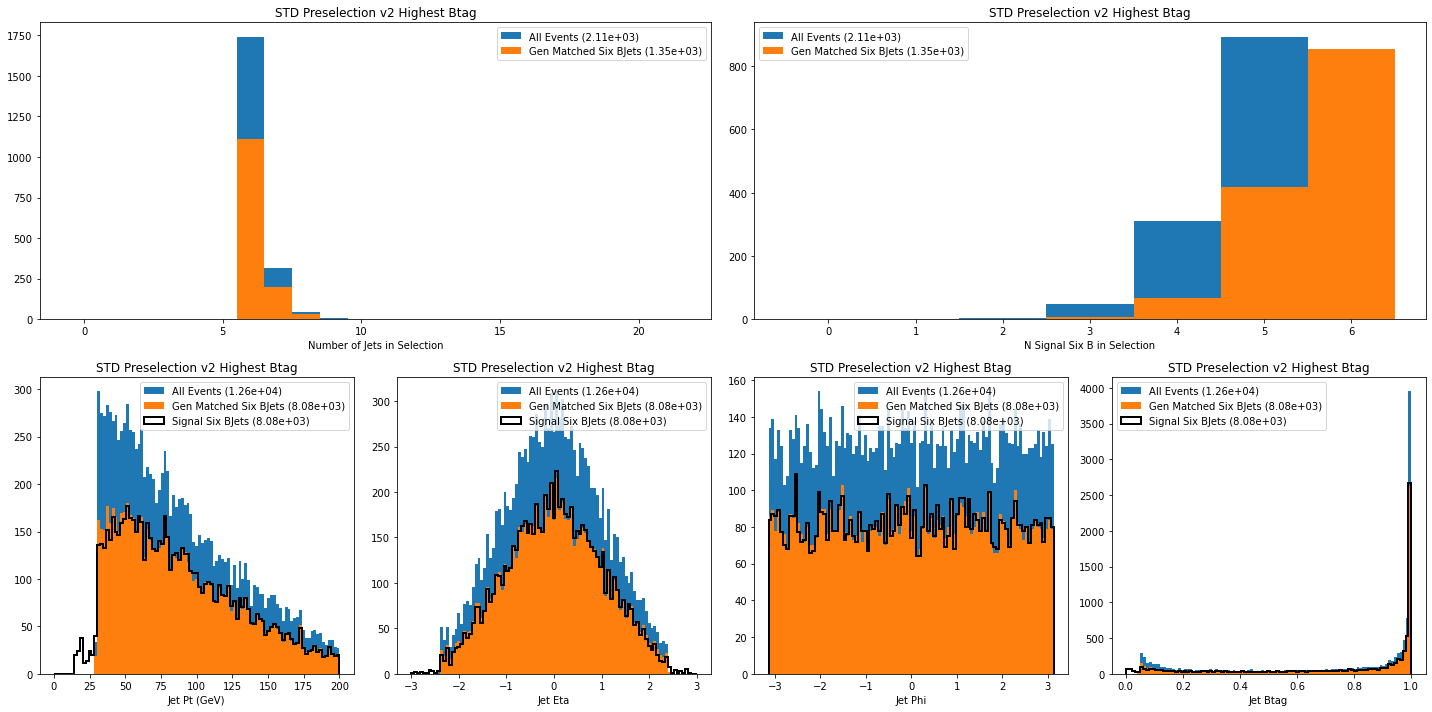

In [19]:
info = {
    "mask":event_presel_v2_mask,
    "title":"STD Preselection v2 Highest Btag",
    "selected":btag_v2_preselected,
    "signal_selected":signal_btag_v2_preselected,
    "sixb_count":sixb_count_v2_presel_btag,
    "signal_sixb_count":signal_sixb_count_v2_presel_btag,
    "jet_mask":jet_presel_v2_mask,
    "saveas":"presel_v2_high_btag.png"
}
presel_study(**info)